<a href="https://colab.research.google.com/github/kavinesh8476/Main_Project/blob/main/project_phase_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Kaggle likes notebook version of tqdm
from shapely import wkt

# Check GPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Device: {DEVICE}")

✅ Device: cpu


In [ ]:
# 1. Define where we will save the masks (Writable Directory)
MASK_DIR = '/kaggle/working/masks'
os.makedirs(MASK_DIR, exist_ok=True)

# 2. Find the Input Dataset Path
# We look for a folder containing 'train' and 'images'
INPUT_DIR = None
print("Searching for dataset...")
for root, dirs, files in os.walk('/kaggle/input'):
    if 'images' in dirs and 'labels' in dirs:
        INPUT_DIR = root
        break

if INPUT_DIR:
    print(f"✅ Found Dataset at: {INPUT_DIR}")
else:
    print("❌ Could not find dataset. Did you add the xBD dataset via 'Add Input'?")

# 3. Find your uploaded Model
MODEL_PATH = None
for root, dirs, files in os.walk('/kaggle/input'):
    for file in files:
        if file.endswith('.pth'):
            MODEL_PATH = os.path.join(root, file)
            print(f"✅ Found Model at: {MODEL_PATH}")
            break

Searching for dataset...
✅ Found Dataset at: /kaggle/input/xview2-challenge-dataset-train-and-test/train/train
✅ Found Model at: /kaggle/input/myspadanetmodel/spadanet_saved_manually.pth


In [ ]:
DAMAGE_MAP = {"no-damage": 1, "minor-damage": 2, "major-damage": 3, "destroyed": 4, "un-classified": 1}

def create_masks_kaggle():
    if not INPUT_DIR: return

    label_dir = os.path.join(INPUT_DIR, 'labels')
    # Limit to 100 images for quick testing demo (Remove [:100] for full run)
    json_files = [f for f in os.listdir(label_dir) if f.endswith('.json') and 'post' in f]

    print(f"Processing {len(json_files)} files...")

    for json_file in tqdm(json_files):
        mask_name = json_file.replace('.json', '.png')
        save_path = os.path.join(MASK_DIR, mask_name)

        # Skip if already exists
        if os.path.exists(save_path): continue

        with open(os.path.join(label_dir, json_file), 'r') as f:
            data = json.load(f)

        # Robust Height/Width Get
        meta = data.get('metadata', {})
        h = meta.get('img_height') or meta.get('height') or 1024
        w = meta.get('img_width') or meta.get('width') or 1024

        mask = np.zeros((h, w), dtype=np.uint8)

        if 'features' in data and 'xy' in data['features']:
            for feature in data['features']['xy']:
                subtype = feature['properties'].get('subtype', 'no-damage')
                val = DAMAGE_MAP.get(subtype, 1)
                poly = wkt.loads(feature['wkt'])
                coords = np.array(list(poly.exterior.coords), np.int32)
                cv2.fillPoly(mask, [coords], val)

        cv2.imwrite(save_path, mask)
    print("✅ Masks Generated in /kaggle/working/masks")

create_masks_kaggle()

Processing 2799 files...


  0%|          | 0/2799 [00:00<?, ?it/s]

✅ Masks Generated in /kaggle/working/masks


In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1), nn.BatchNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x):
        psi = self.relu(self.W_g(g) + self.W_x(x))
        return x * self.psi(psi)

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=6, out_channels=5):
        super().__init__()
        self.e1 = ConvBlock(in_channels, 64)
        self.e2 = ConvBlock(64, 128)
        self.e3 = ConvBlock(128, 256)
        self.e4 = ConvBlock(256, 512)
        self.pool = nn.MaxPool2d(2, 2)
        self.b = ConvBlock(512, 1024)
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.att1 = AttentionBlock(512, 512, 256)
        self.d1 = ConvBlock(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.att2 = AttentionBlock(256, 256, 128)
        self.d2 = ConvBlock(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.att3 = AttentionBlock(128, 128, 64)
        self.d3 = ConvBlock(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.att4 = AttentionBlock(64, 64, 32)
        self.d4 = ConvBlock(128, 64)
        self.out = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        x1 = self.e1(x)
        p1 = self.pool(x1)
        x2 = self.e2(p1)
        p2 = self.pool(x2)
        x3 = self.e3(p2)
        p3 = self.pool(x3)
        x4 = self.e4(p3)
        p4 = self.pool(x4)
        b = self.b(p4)
        d1 = self.up1(b)
        x4 = self.att1(d1, x4)
        d1 = torch.cat((x4, d1), dim=1)
        d1 = self.d1(d1)
        d2 = self.up2(d1)
        x3 = self.att2(d2, x3)
        d2 = torch.cat((x3, d2), dim=1)
        d2 = self.d2(d2)
        d3 = self.up3(d2)
        x2 = self.att3(d3, x2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.d3(d3)
        d4 = self.up4(d3)
        x1 = self.att4(d4, x1)
        d4 = torch.cat((x1, d4), dim=1)
        d4 = self.d4(d4)
        return self.out(d4)

In [ ]:
class KaggleDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = os.path.join(img_dir, 'images')
        self.mask_dir = mask_dir
        # Only load files that exist in our generated masks folder
        self.files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]

    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        post_name = self.files[idx]
        pre_name = post_name.replace('post', 'pre')

        # Load Images
        post = cv2.imread(os.path.join(self.img_dir, post_name))
        post = cv2.cvtColor(post, cv2.COLOR_BGR2RGB)

        pre_path = os.path.join(self.img_dir, pre_name)
        if os.path.exists(pre_path):
            pre = cv2.imread(pre_path)
            pre = cv2.cvtColor(pre, cv2.COLOR_BGR2RGB)
        else:
            pre = post.copy()

        mask = cv2.imread(os.path.join(self.mask_dir, post_name), 0)

        # Resize
        SIZE = 256
        post = cv2.resize(post, (SIZE, SIZE)) / 255.0
        pre = cv2.resize(pre, (SIZE, SIZE)) / 255.0
        mask = cv2.resize(mask, (SIZE, SIZE), interpolation=cv2.INTER_NEAREST)

        combined = np.concatenate((pre, post), axis=2)
        t_img = torch.from_numpy(combined.astype(np.float32)).permute(2, 0, 1)
        t_mask = torch.from_numpy(mask.astype(np.longlong))

        return t_img, t_mask

# Init Loader
if INPUT_DIR and os.path.exists(MASK_DIR):
    ds = KaggleDataset(INPUT_DIR, MASK_DIR)
    loader = DataLoader(ds, batch_size=4, shuffle=True)
    print("✅ DataLoader Ready")

✅ DataLoader Ready


✅ Model Weights Loaded!


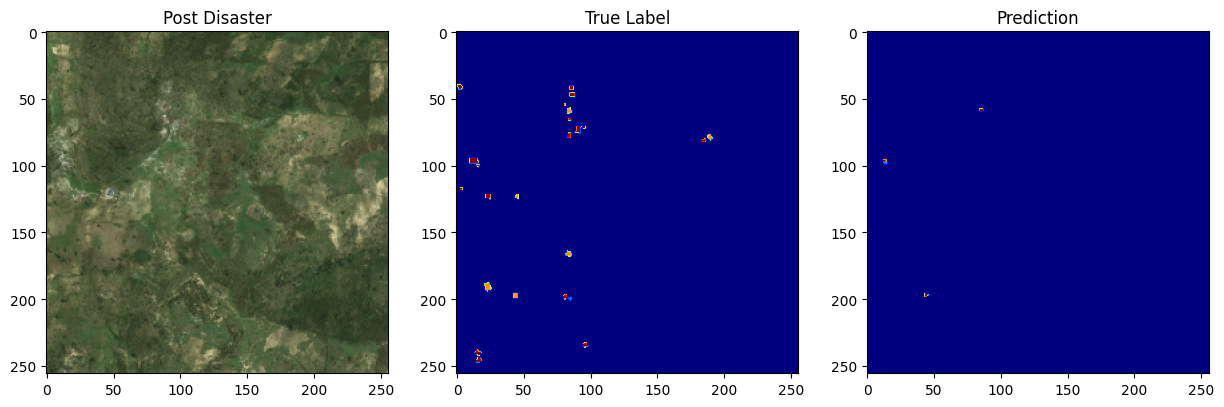

In [ ]:
model = AttentionUNet(in_channels=6, out_channels=5).to(DEVICE)

if MODEL_PATH:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print("✅ Model Weights Loaded!")

    # Visualize
    data, target = next(iter(loader))
    data = data.to(DEVICE)
    pred = model(data).argmax(dim=1).cpu().numpy()

    img = data[0].cpu().permute(1, 2, 0).numpy()[:,:,3:] # Post image

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img)
    ax[0].set_title("Post Disaster")
    ax[1].imshow(target[0], cmap='jet', vmin=0, vmax=4)
    ax[1].set_title("True Label")
    ax[2].imshow(pred[0], cmap='jet', vmin=0, vmax=4)
    ax[2].set_title("Prediction")
    plt.show()
else:
    print("❌ Model path not found.")

running evaluation loop (this might take a minute)...


  0%|          | 0/700 [00:00<?, ?it/s]


✅ Global Pixel Accuracy: 96.60%

📊 Classification Report:
              precision    recall  f1-score   support

  Background       0.98      1.00      0.99 172474702
   No Damage       0.69      0.66      0.68   8112303
       Minor       0.38      0.00      0.00    996010
       Major       0.38      0.00      0.00   1258471
   Destroyed       0.83      0.29      0.43    593778

    accuracy                           0.97 183435264
   macro avg       0.65      0.39      0.42 183435264
weighted avg       0.96      0.97      0.96 183435264



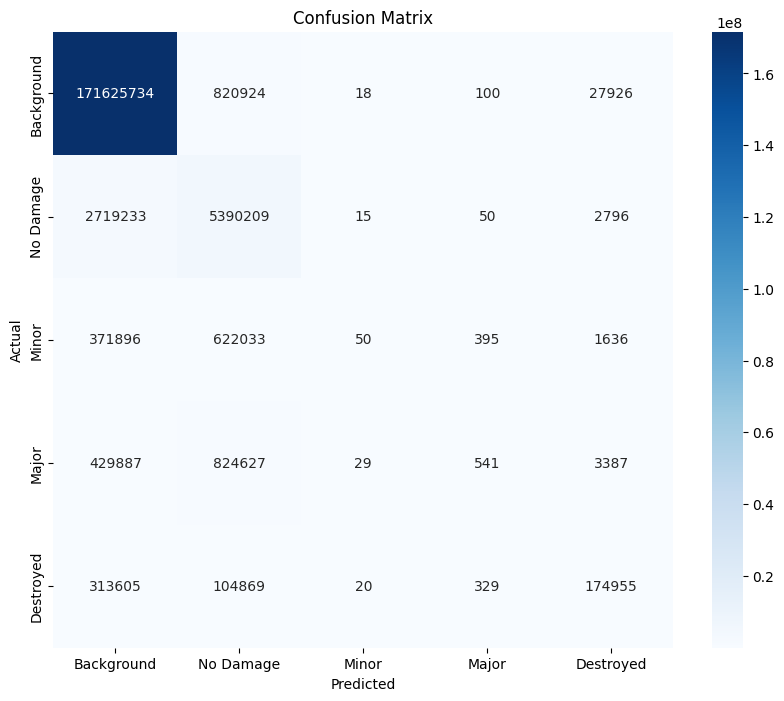

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def evaluate_model(model, loader, device):
    model.eval()

    # Trackers
    all_preds = []
    all_targets = []

    print("running evaluation loop (this might take a minute)...")

    with torch.no_grad():
        for data, targets in tqdm(loader):
            data = data.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(data)
            preds = torch.argmax(outputs, dim=1) # Get class ID (0-4)

            # Move to CPU and flatten to 1D list
            preds_flat = preds.cpu().numpy().flatten()
            targets_flat = targets.cpu().numpy().flatten()

            all_preds.extend(preds_flat)
            all_targets.extend(targets_flat)

    # Convert to arrays
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # --- 1. GLOBAL ACCURACY ---
    accuracy = (all_preds == all_targets).mean()
    print(f"\n✅ Global Pixel Accuracy: {accuracy*100:.2f}%")

    # --- 2. DETAILED REPORT ---
    class_names = ["Background", "No Damage", "Minor", "Major", "Destroyed"]
    print("\n📊 Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=class_names, zero_division=0))

    # --- 3. CONFUSION MATRIX ---
    cm = confusion_matrix(all_targets, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return cm

# --- FIX IS HERE: Use 'loader', not 'val_loader' ---
if 'loader' in globals():
    cm = evaluate_model(model, loader, DEVICE)
else:
    print("❌ Error: 'loader' is not defined. Please run Cell 5 (Dataset Loader) again.")